In [1]:
!/opt/conda/default/bin/pip install matplotlib

     |████████████████████████████████| 11.5 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 7.0 MB/s  eta 0:00:01


In [2]:
import numpy as np
import hail as hl
from hail import methods
from hail.expr import matrix_table_source
import scipy as sp
import pandas as pd
from math import sqrt, pi, ceil
from random import randint, choice
import matplotlib.pyplot as plt
import pandas as pd
import time

## Grouping and NDArray methods from Tim and Dan

In [3]:
# Functions for operating with Tables of ndarrays in Hail (from Tim)

from hail.expr import Expression, ExpressionException, \
    expr_float64, expr_call, expr_any, expr_numeric, expr_array, \
    expr_locus, \
    analyze, check_entry_indexed, check_row_indexed, \
    matrix_table_source, table_source

# Only groups by rows, NOT COLUMNS
def matrix_table_to_table_of_ndarrays(field, group_size, tmp_path = '/tmp/nd_table.ht'):
    """

    The returned table has two fields: 'row_group_number' and 'ndarray'.

    Examples
    --------
    >>> ht = matrix_table_to_table_of_ndarrays(mt.GT.n_alt_alleles(), 100)

    Parameters
    ----------
    field
    group_size
    tmp_path

    Returns
    -------

    """
    mt = matrix_table_source('matrix_table_to_table_of_ndarrays/x', field)
    mt = mt.select_entries(x = field)
    ht = mt.localize_entries(entries_array_field_name='entries')
    # now ht.entries is an array of structs with one field, x

    # we'll also want to mean-impute/variance-normalize/etc here
    ht = ht.select(xs = ht.entries.map(lambda e: e['x']))
    # now ht.xs is an array of float64

    # now need to produce groups of G
    ht = ht.add_index()
    ht = ht.group_by(row_group_number= hl.int32(ht.idx // group_size)) \
        .aggregate(ndarray=hl.nd.array(hl.agg.collect(ht.xs)))
    # may require a .T on ndarray

    return ht.checkpoint(tmp_path, overwrite=True)

def chunk_ndarray(a, group_size):
    """Chunks a NDarray along the first axis in chunks of `group_size`.
    Parameters
    ----------
    a
    group_size
    -------

    """
    n_groups = ceil(a.shape[0] / group_size)
    groups = []
    for i in range(n_groups):
        start = i * group_size
        if i == n_groups - 1:
            end = a.shape[0]
        else:
            end = (i + 1) * group_size
        groups.append(a[start:end, :])
    return groups


# Concatenate the ndarrays with a blocked Table
def concatBlocked(A):
    blocks = A.ndarray.collect()
    big_mat = np.concatenate(blocks, axis=0)
    ht = ndarray_to_table([big_mat])
    return ht

def concatToNumpy(A):
    blocks = A.ndarray.collect()
    big_mat = np.concatenate(blocks, axis=0)
    return big_mat

def ndarray_to_table(chunked_arr):
    structs = [hl.struct(row_group_number = idx, ndarray = block)
               for idx, block in enumerate(chunked_arr)]
    ht = hl.Table.parallelize(structs)
    ht = ht.key_by('row_group_number')
    return ht

# function to multiply two blocks, given the two blocks
# returns struct in form of array but not ndarray, includes the shape in the struct
# to change the result product directly back into a ndarray we need to use from_column_major
def block_product(left, right):
    product = left @ right     
    n_rows, n_cols = product.shape
    return hl.struct(
        shape=product.shape,
        block=hl.range(hl.int(n_rows * n_cols)).map(
            lambda absolute: product[absolute % n_rows, absolute // n_rows]))

# takes in output of block_product
def block_aggregate(prod):
    shape = prod.shape
    block = prod.block
    return hl.nd.from_column_major(
        hl.agg.array_sum(block),
        hl.agg.take(shape, 1)[0])

# returns flat array
def to_column_major(ndarray):
    n_rows, n_cols = ndarray.shape
    return hl.range(hl.int(n_rows * n_cols)).map(
        lambda absolute: ndarray[absolute % n_rows, absolute // n_rows])

# hl.nd.from_column_major(thing.the_sum, thing.the_shape)

## Blanczos Algorithm

In [4]:
# Algorithm step: multiplying H0 = A @ G

# METHOD
# Multiply a row-blocked matrix by a local non-blocked matrix
# First step of algorithm

# Usage:
# assumes blocks in blocked matrix are named ndarray
# A is a table, B is a Hail ndarray
# returns a table

# Example:
# H0 = matmul_rowblocked_nonblocked(data, G)

def matmul_rowblocked_nonblocked(A, B):
    temp = A.annotate_globals(mat = B)
    temp = temp.annotate(ndarray = temp.ndarray @ temp.mat)
    temp = temp.select(temp.ndarray)
    temp = temp.drop(temp.mat)
    return temp


# Algorithm step: intermediate operation of multiplying At @ (A @ G) = At @ H0

# METHOD
# Multiply a column-blocked matrix by a row-blocked matrix 
# as a blockmatrix multiplcation and then sum
# Second step of algorithm

# Usage:
# pass in matrix A normally, blocked in rows - this specifically expects A to need to be transposed
# assumes blocks in blocked matrix are named ndarray
# A and B are both tables
# returns a hail ndarray

# Example:
# G1 = matmul_colblocked_rowblocked(data, H0)

# def matmul_colblocked_rowblocked(A, B):
#     temp = A.transmute(ndarray = block_product(A.ndarray.transpose(), B[A.row_group_number].ndarray))
#     result_arr_sum = temp.aggregate(block_aggregate(temp.ndarray))
#     return result_arr_sum

def matmul_colblocked_rowblocked(A, B):
    temp = A.transmute(ndarray = A.ndarray.transpose() @ B[A.row_group_number].ndarray)
    return temp.aggregate(hl.agg.ndarray_sum(temp.ndarray))

# Algorithm step: perform QR decomposition of Hq and compute T = Q^T @ A
# Perform QR decomposition of a row-blocked matrix
# Third and fourth step of algorithm

def computeNextH(A, H):
    nextG = matmul_colblocked_rowblocked(A, H)
    return matmul_rowblocked_nonblocked(A, nextG)

In [5]:
def hailBlanczos(A, G, m, n, k, l, q, block_size):
    
    # assert l > k
    # assert (q+1)*l <= (n - k)
    # assert n <= m
    
    start = time.time()
    
    Hi = matmul_rowblocked_nonblocked(A, G)
    npH = concatToNumpy(Hi)
    for j in range(0, q):
        Hj = computeNextH(A, Hi)
        npH = np.concatenate((npH, concatToNumpy(Hj)), axis=1)
        Hi = Hj
    
    # assert npH.shape == (m, (q+1)*l)
    # perform QR decomposition on unblocked version of H
    Q, R = np.linalg.qr(npH)
    # assert Q.shape == (m, (q+1)*l)
    # block Q's rows into the same number of blocks that A has
    blocked_Q_table = ndarray_to_table(chunk_ndarray(Q, block_size))
    
    T = matmul_colblocked_rowblocked(blocked_Q_table, A)
    # assert T.shape == ((q+1)*l, n)
    
    U, S, W = np.linalg.svd(T, full_matrices=False)
    # assert U.shape == ((q+1)*l, n)
    # assert S.shape == (n,)
    # assert W.shape == (n, n)
    
    sing_val = S[k]
    
    V = matmul_rowblocked_nonblocked(blocked_Q_table, U)
    arr_V = concatToNumpy(V)
    
    end = time.time()
    
    truncV = arr_V[:,:k]
    truncS = S[:k]
    truncW = W[:k,:]
    
    #bound, satC = blanczosErrorB(truncV, np.diag(truncS), truncW.transpose(), m, n, k, q, concatToNumpy(A), sing_val)
    
    return truncV, truncS, truncW, sing_val, Q, end - start #, bound, satC


## NumPy implementation from other notebook

In [6]:
# ALL TRANSPOSED FROM ABOVE IMPLEMENTATION

def hwe_normalize(call_expr):
    mt = call_expr._indices.source
    mt = mt.select_entries(__gt=call_expr.n_alt_alleles())
    mt = mt.annotate_rows(__AC=hl.agg.sum(mt.__gt),
                          __n_called=hl.agg.count_where(hl.is_defined(mt.__gt)))
    mt = mt.filter_rows((mt.__AC > 0) & (mt.__AC < 2 * mt.__n_called))

    n_variants = mt.count_rows()
    if n_variants == 0:
        raise FatalError("hwe_normalized: found 0 variants after filtering out monomorphic sites.")

    mt = mt.annotate_rows(__mean_gt=mt.__AC / mt.__n_called)
    mt = mt.annotate_rows(
        __hwe_scaled_std_dev=hl.sqrt(mt.__mean_gt * (2 - mt.__mean_gt) * n_variants / 2))
    mt = mt.unfilter_entries()

    normalized_gt = hl.or_else((mt.__gt - mt.__mean_gt) / mt.__hwe_scaled_std_dev, 0.0)
    return normalized_gt

#Blanczos paper error bound 4.23
def blanczosErrorA(U, S, V, m, n, k, q, A, k1th_sing_val):
    norm_diff = np.linalg.norm(A - U @ S @ V.transpose())
    bound = 100 * l * (((m-k)/l) ** (1/(4*q + 2))) * k1th_sing_val
    print('value:', norm_diff, 'bound/upper limit:', bound)
    return norm_diff <= bound

def blanczosErrorB(U, S, V, m, n, k, q, A, k1th_sing_val):
    C = 1
    norm_diff = np.linalg.norm(A - U @ S @ V.transpose())
    bound = C * (m ** (1/(4*q))) * k1th_sing_val
    satisfyingC = norm_diff / bound
    print('difference A - USV:', norm_diff, 'bound/upper limit:', bound)
    print('C constant needed to satisfy bound:', satisfyingC)
    return norm_diff <= bound, satisfyingC

def normQQtA(A, Q):
    return np.linalg.norm(A - Q @ Q.transpose() @ A)

def numpyBlanczos(A, m, n, k, l, q, G):

    assert l > k
    # assert (q+1)*l <= (m - k)
    assert m <= n

    # G = np.random.normal(0, 1, (l, m))
    R = G @ A
    # AtA = A.transpose() @ A
    listR = [R]
    for i in range(0, q):
        Ri = (listR[i] @ A.transpose()) @ A
        listR.append(Ri)
        R = np.concatenate((R, Ri), axis=0)

    assert R.shape == ((q+1)*l, n)
    (Q, S) = np.linalg.qr(R.transpose())
    assert Q.shape == (n, (q+1)*l)
    assert S.shape == ((q+1)*l, (q+1)*l)

    T = A @ Q
    assert T.shape == (m, (q+1)*l)
    
    (Tu, Ts, Tw) = np.linalg.svd(T, full_matrices=False)
    assert Tu.shape, (m, (q+1)*l)
    print(Ts.shape, (q+1)*l)
    assert Ts.shape == ((q+1)*l,)
    assert Tw.shape == ((q+1)*l, (q+1)*l)
    
    sing_val = Ts[k]
    
    V = Q @ Tw
    
    bound = blanczosErrorB(Tu, np.diag(Ts), V, m, n, k, q, A, sing_val)
    
    return Tu[:,:k], Ts[:k], V[:k,:], sing_val, Q


## Run NumPy and Hail implementations on the same data

In [7]:
def makeSharedData(model_input, block_size):
    
    # we should have m > n for hail implementation
    mt = hl.balding_nichols_model(*model_input)
    
    mt.write("balding_nichols_data.mt", overwrite=True)
    mt = hl.read_matrix_table("balding_nichols_data.mt")
    
    mt = mt.transmute_entries(n_alt = hl.float64(mt.GT.n_alt_alleles())) 
    table = matrix_table_to_table_of_ndarrays(mt.n_alt, block_size, tmp_path='/tmp/test_table.ht')
    
    # for numpy implementation we want transposed version so m < n
    np_matrix = np.asmatrix(concatToNumpy(table))

    return table, np_matrix, mt # THIS WAS PREVIOUSLY JUST RETURNING table, np_matrix

# m = 1117
# n = 97
# block_size = 4
# hailA, numpyA = makeSharedData((3, n, m), block_size)

# doesn't account for differences due to transposing
# hailV not necessarily supposed to be the same as blanczosU

In [8]:
# k = 10
# l = k + 2
# q = 3
# G = np.random.normal(0, 1, (n,l))

In [9]:
def timeNumpyLibrary(data):
    start = time.time()
    _, S, _ = np.linalg.svd(data, full_matrices=False)
    end = time.time()
    return end - start

def convertSVDtoPCA(data, U, S, V):
    # might need to center data first??
    m = data.shape[0]
    scores = sqrt(m - 1) * U
    loadings = V @ S / sqrt(m - 1)
    eigens = S @ S / sqrt(m - 1)
    return eigens, scores, loadings

In [10]:
# hailV, hailS, hailW, hailSingVal, hailQ, _ = hailBlanczos(hailA, hl.nd.array(G), m, n, k, l, q, block_size)

In [11]:
# _, npS, _ = np.linalg.svd(numpyA.transpose(), full_matrices=False)

# hailS - npS[:k]

In [12]:
#numpyU, numpyS, numpyV, numpySingVal, numpyQ = numpyBlanczos(numpyA.transpose(), n, m, k, l, q, G.transpose())

In [13]:
# print('largest singular value from hail:', hailS[0])
# print('smallest singular value from hail:', hailS[k-1])
# print(hailS.shape)
# print(numpyS.shape)
# hailS - numpyS

In [14]:
# normQQtA(numpyA.transpose(), hailQ)

In [15]:
# print(numpyA.shape)
# print(numpyQ.shape)
# normQQtA(numpyA, numpyQ.transpose())

In [25]:
def test_blanczos_against_hail():
        
#     hl.utils.get_1kg('data/')
#     hl.import_vcf('data/1kg.vcf.bgz').write('data/1kg.mt', overwrite=True)
#     mt = hl.read_matrix_table('data/1kg.mt')
    
#     mt = hl.balding_nichols_model(3, 100, 1000)
#     mt = mt.transmute_entries(n_alt = hl.float64(mt.GT.n_alt_alleles()))

#     ht = mt.localize_entries("ent", "sample") 
#     ht = ht.transmute(n_alt = hl.nd.array(mt.n_alt))
#     rows = ht.n_alt.collect()
#     np_matrix = np.asmatrix(np.concatenate(rows, axis=0))

    _, np_matrix, mt = makeSharedData((3, 100, 1000), 4)

    blanczos_u, blanczos_s, blanczos_v = hl._blanczos_pca(hl.int(hl.is_defined(mt.n_alt)), k=3)
    blanczos_eigens, blanczos_scores, blanczos_loadings = convertSVDtoPCA(np_matrix, blanczos_u, blanczos_s, blanczos_v)
    eigens, scores, loadings = hl.pca(hl.int(hl.is_defined(mt.n_alt)), k=3)
    #diff = blanczos_vals - np_vals
    print(blanczos_vals)
    #print(hail_vals)
    return 

test_blanczos_against_hail()

2020-08-07 22:14:21 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-07 22:14:21 Hail: INFO: Coerced sorted dataset
2020-08-07 22:14:29 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-07 22:14:33 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:37 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-07 22:14:38 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:39 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:41 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:42 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:43 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:44 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:44 Hail: INFO: Ordering u

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 100)

In [17]:
hl.utils.get_1kg('data/')
hl.import_vcf('data/1kg.vcf.bgz').write('data/1kg.mt', overwrite=True)
mt = hl.read_matrix_table('data/1kg.mt')

def cleanMissingData(mt):

    call_expr = mt.GT
    mt = call_expr._indices.source
    mt = mt.select_entries(__gt=call_expr.n_alt_alleles())
    mt = mt.annotate_rows(__AC=hl.agg.sum(mt.__gt),
                          __n_called=hl.agg.count_where(hl.is_defined(mt.__gt)))
    mt = mt.filter_rows((mt.__AC > 0) & (mt.__AC < 2 * mt.__n_called))

    n_variants = mt.count_rows()
    if n_variants == 0:
        raise FatalError("hwe_normalized: found 0 variants after filtering out monomorphic sites.")

    mt = mt.annotate_rows(__mean_gt=mt.__AC / mt.__n_called)
    mt = mt.annotate_rows(__hwe_scaled_std_dev=hl.sqrt(mt.__mean_gt * (2 - mt.__mean_gt) * n_variants / 2))
    mt = mt.unfilter_entries()

    mt = matrix_table_source('hwe_normalized_pca/call_expr', hl.or_else((mt.__gt - mt.__mean_gt) / mt.__hwe_scaled_std_dev, 0.0))
    # normalized_gt = hl.or_else((mt.__gt - mt.__mean_gt) / mt.__hwe_scaled_std_dev, 0.0)

    # mt = hl.linalg.BlockMatrix.from_entry_expr(normalized_gt)

    return mt

cleanMissingData(mt).describe()

2020-08-09 19:34:28 Hail: INFO: 1KG files found
2020-08-09 19:34:29 Hail: INFO: Coerced sorted dataset
2020-08-09 19:34:42 Hail: INFO: wrote matrix table with 10879 rows and 284 columns in 1 partition to data/1kg.mt


----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DP: int32, 
        DS: bool, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQ0: int32, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        set: str
    }
    '__AC': int64
    '__n_called': int64
    '__mean_gt': float32
    '__hwe_scaled_std_dev': float64
----------------------------------------
Entry fields:
    '__gt': int32
-----------------

In [ ]:
df = pd.DataFrame(columns=['M', 'N', 'block size', 'K', 'L', 'Q', 'blanczos time', 'numpy time'])

# references a dataframe df not passed into the function
def loop(i, m, n, block_size, k, l, q):
    
    print("loop attempt ", i, ' with m:', m, ', n:', n, ', m*n =', m*n, ', and q:', q)

    try: 
        assert l > k
        assert n <= m
    except Exception as e:
        print(e)
        return

    try:
        table, mat = makeSharedData((3, n, m), block_size)
    except Exception as e:
        print(e)
        print('failed to make data with ', (m, n))
        return
    
    try:
        G = hl.nd.array(np.random.normal(0, 1, (n,l)))
        _, S, _, _, _, hail_time  = hailBlanczos(table, G, m, n, k, l, q, block_size)
        numpy_time = timeNumpyLibrary(mat)
        df.loc[i] = [m, n, block_size, k, l, q, hail_time, numpy_time]
    except Exception as e:
        print(e)
        print('failed during blanczos algorithm with ', (m, n))
        return
        
    return


# for i in range(1, 5):
    
#     randN = randint(100, 1000) #100
#     randM = randint(1000, 10000) #1000
#     randBlockSize = choice([2, 4, 8, 16])
#     K = 10
#     randL = randint(1, 20) + K
#     randQ = randint(1, 4)
    
#     loop(i, randM, randN, randBlockSize, K, randL, randQ)
    
#     df.to_csv('blanczos_data_random.csv')
    

K = 10
i = 0

for L in [K + 2, 2 * K]:
    
    for Q in [1, 2, 3]: 
        
        for m in [100, 500, 1000, 5000]:
            
            for n in [50, 100, 500]:
                
                for block_size in [2, 4, 8, 16, 32]:
                    
                    loop(i, m, n, block_size, K, L, Q)
                    df.to_csv('blanczos_data_combinatorial.csv')
                    i += 1
    

loop attempt  0  with m: 100 , n: 10 , m*n = 1000 , and q: 1


2020-08-05 17:49:37 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 17:49:38 Hail: INFO: Coerced sorted dataset
2020-08-05 17:49:47 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:49:48 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:49:52 Hail: INFO: wrote table with 50 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:49:53 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  1  with m: 100 , n: 10 , m*n = 1000 , and q: 1


2020-08-05 17:49:53 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 17:49:53 Hail: INFO: Coerced sorted dataset
2020-08-05 17:49:59 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:50:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:50:06 Hail: INFO: wrote table with 25 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:50:07 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  2  with m: 100 , n: 10 , m*n = 1000 , and q: 1


2020-08-05 17:50:07 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 17:50:07 Hail: INFO: Coerced sorted dataset
2020-08-05 17:50:14 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:50:15 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:50:18 Hail: INFO: wrote table with 13 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:50:19 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  3  with m: 100 , n: 10 , m*n = 1000 , and q: 1


2020-08-05 17:50:19 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 17:50:19 Hail: INFO: Coerced sorted dataset
2020-08-05 17:50:25 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:50:26 Hail: INFO: Coerced sorted dataset
2020-08-05 17:50:26 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 17:50:30 Hail: INFO: wrote table with 7 rows in 5 partitions to /tmp/test_table.ht
2020-08-05 17:50:31 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  4  with m: 100 , n: 10 , m*n = 1000 , and q: 1


2020-08-05 17:50:31 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 17:50:31 Hail: INFO: Coerced sorted dataset
2020-08-05 17:50:37 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:50:37 Hail: INFO: Coerced sorted dataset
2020-08-05 17:50:37 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 17:50:41 Hail: INFO: wrote table with 4 rows in 3 partitions to /tmp/test_table.ht
2020-08-05 17:50:41 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  5  with m: 100 , n: 50 , m*n = 5000 , and q: 1


2020-08-05 17:50:42 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...
2020-08-05 17:50:42 Hail: INFO: Coerced sorted dataset
2020-08-05 17:50:47 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:50:48 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:50:51 Hail: INFO: wrote table with 50 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:50:53 Hail: INFO: Coerced sorted dataset
2020-08-05 17:50:53 Hail: INFO: Coerced sorted dataset
2020-08-05 17:50:53 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...


loop attempt  6  with m: 100 , n: 50 , m*n = 5000 , and q: 1


2020-08-05 17:50:53 Hail: INFO: Coerced sorted dataset
2020-08-05 17:50:58 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:50:59 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:51:02 Hail: INFO: wrote table with 25 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:51:03 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:03 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:03 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...


loop attempt  7  with m: 100 , n: 50 , m*n = 5000 , and q: 1


2020-08-05 17:51:03 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:09 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:51:09 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:51:11 Hail: INFO: wrote table with 13 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:51:12 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:13 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:13 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...


loop attempt  8  with m: 100 , n: 50 , m*n = 5000 , and q: 1


2020-08-05 17:51:13 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:19 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:51:20 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:20 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 17:51:24 Hail: INFO: wrote table with 7 rows in 5 partitions to /tmp/test_table.ht
2020-08-05 17:51:25 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:25 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:25 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...


loop attempt  9  with m: 100 , n: 50 , m*n = 5000 , and q: 1


2020-08-05 17:51:25 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:33 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:51:33 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:33 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 17:51:36 Hail: INFO: wrote table with 4 rows in 3 partitions to /tmp/test_table.ht
2020-08-05 17:51:37 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:37 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:37 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  10  with m: 100 , n: 100 , m*n = 10000 , and q: 1


2020-08-05 17:51:38 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:45 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:51:46 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:51:49 Hail: INFO: wrote table with 50 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:51:50 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:50 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:50 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  11  with m: 100 , n: 100 , m*n = 10000 , and q: 1


2020-08-05 17:51:51 Hail: INFO: Coerced sorted dataset
2020-08-05 17:51:58 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:51:58 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:52:02 Hail: INFO: wrote table with 25 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:52:03 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:03 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:03 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  12  with m: 100 , n: 100 , m*n = 10000 , and q: 1


2020-08-05 17:52:04 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:11 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:52:12 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:52:14 Hail: INFO: wrote table with 13 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:52:15 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:16 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:16 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  13  with m: 100 , n: 100 , m*n = 10000 , and q: 1


2020-08-05 17:52:16 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:23 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:52:24 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:24 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 17:52:27 Hail: INFO: wrote table with 7 rows in 5 partitions to /tmp/test_table.ht
2020-08-05 17:52:28 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:28 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:28 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  14  with m: 100 , n: 100 , m*n = 10000 , and q: 1


2020-08-05 17:52:28 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:36 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:52:36 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:36 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 17:52:40 Hail: INFO: wrote table with 4 rows in 3 partitions to /tmp/test_table.ht
2020-08-05 17:52:41 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:41 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:41 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...


loop attempt  15  with m: 100 , n: 500 , m*n = 50000 , and q: 1

loop attempt  16  with m: 100 , n: 500 , m*n = 50000 , and q: 1

loop attempt  17  with m: 100 , n: 500 , m*n = 50000 , and q: 1

loop attempt  18  with m: 100 , n: 500 , m*n = 50000 , and q: 1

loop attempt  19  with m: 100 , n: 500 , m*n = 50000 , and q: 1

loop attempt  20  with m: 500 , n: 10 , m*n = 5000 , and q: 1


2020-08-05 17:52:41 Hail: INFO: Coerced sorted dataset
2020-08-05 17:52:49 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:52:50 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:52:53 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:52:54 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  21  with m: 500 , n: 10 , m*n = 5000 , and q: 1


2020-08-05 17:52:54 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...
2020-08-05 17:52:55 Hail: INFO: Coerced sorted dataset
2020-08-05 17:53:02 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:53:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:53:06 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:53:07 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  22  with m: 500 , n: 10 , m*n = 5000 , and q: 1


2020-08-05 17:53:07 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...
2020-08-05 17:53:08 Hail: INFO: Coerced sorted dataset
2020-08-05 17:53:15 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:53:16 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:53:19 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:53:20 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  23  with m: 500 , n: 10 , m*n = 5000 , and q: 1


2020-08-05 17:53:21 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...
2020-08-05 17:53:21 Hail: INFO: Coerced sorted dataset
2020-08-05 17:53:28 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:53:29 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:53:32 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:53:33 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  24  with m: 500 , n: 10 , m*n = 5000 , and q: 1


2020-08-05 17:53:33 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...
2020-08-05 17:53:33 Hail: INFO: Coerced sorted dataset
2020-08-05 17:53:40 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:53:41 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:53:44 Hail: INFO: wrote table with 16 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:53:45 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  25  with m: 500 , n: 50 , m*n = 25000 , and q: 1


2020-08-05 17:53:45 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...
2020-08-05 17:53:45 Hail: INFO: Coerced sorted dataset
2020-08-05 17:53:53 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:53:54 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:53:57 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:53:58 Hail: INFO: Coerced sorted dataset
2020-08-05 17:53:59 Hail: INFO: Coerced sorted dataset


loop attempt  26  with m: 500 , n: 50 , m*n = 25000 , and q: 1


2020-08-05 17:53:59 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...
2020-08-05 17:53:59 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:06 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:54:07 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:54:11 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:54:12 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:12 Hail: INFO: Coerced sorted dataset


loop attempt  27  with m: 500 , n: 50 , m*n = 25000 , and q: 1


2020-08-05 17:54:13 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...
2020-08-05 17:54:13 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:20 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:54:21 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:54:25 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:54:26 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:26 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:26 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...


loop attempt  28  with m: 500 , n: 50 , m*n = 25000 , and q: 1


2020-08-05 17:54:27 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:32 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:54:33 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:54:36 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:54:37 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:37 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:37 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...


loop attempt  29  with m: 500 , n: 50 , m*n = 25000 , and q: 1


2020-08-05 17:54:37 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:44 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:54:45 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:54:48 Hail: INFO: wrote table with 16 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:54:49 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:50 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:50 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...


loop attempt  30  with m: 500 , n: 100 , m*n = 50000 , and q: 1


2020-08-05 17:54:50 Hail: INFO: Coerced sorted dataset
2020-08-05 17:54:56 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:54:57 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:55:00 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:55:01 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:02 Hail: INFO: Coerced sorted dataset


loop attempt  31  with m: 500 , n: 100 , m*n = 50000 , and q: 1


2020-08-05 17:55:02 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...
2020-08-05 17:55:02 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:08 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:55:08 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:55:11 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:55:12 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:12 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:13 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...


loop attempt  32  with m: 500 , n: 100 , m*n = 50000 , and q: 1


2020-08-05 17:55:13 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:20 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:55:21 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:55:24 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:55:26 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:26 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:26 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...


loop attempt  33  with m: 500 , n: 100 , m*n = 50000 , and q: 1


2020-08-05 17:55:26 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:33 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:55:34 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:55:38 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:55:39 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:39 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:40 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...


loop attempt  34  with m: 500 , n: 100 , m*n = 50000 , and q: 1


2020-08-05 17:55:40 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:47 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:55:48 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:55:51 Hail: INFO: wrote table with 16 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:55:52 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:53 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:53 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...


loop attempt  35  with m: 500 , n: 500 , m*n = 250000 , and q: 1


2020-08-05 17:55:53 Hail: INFO: Coerced sorted dataset
2020-08-05 17:55:59 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:56:00 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:56:03 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:56:05 Hail: INFO: Coerced sorted dataset
2020-08-05 17:56:06 Hail: INFO: Coerced sorted dataset


loop attempt  36  with m: 500 , n: 500 , m*n = 250000 , and q: 1


2020-08-05 17:56:06 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...
2020-08-05 17:56:06 Hail: INFO: Coerced sorted dataset
2020-08-05 17:56:12 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:56:13 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:56:16 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:56:18 Hail: INFO: Coerced sorted dataset
2020-08-05 17:56:18 Hail: INFO: Coerced sorted dataset


loop attempt  37  with m: 500 , n: 500 , m*n = 250000 , and q: 1


2020-08-05 17:56:19 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...
2020-08-05 17:56:19 Hail: INFO: Coerced sorted dataset
2020-08-05 17:56:24 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:56:25 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:56:29 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:56:30 Hail: INFO: Coerced sorted dataset
2020-08-05 17:56:31 Hail: INFO: Coerced sorted dataset


loop attempt  38  with m: 500 , n: 500 , m*n = 250000 , and q: 1


2020-08-05 17:56:31 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...
2020-08-05 17:56:31 Hail: INFO: Coerced sorted dataset
2020-08-05 17:56:38 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:56:38 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:56:41 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:56:43 Hail: INFO: Coerced sorted dataset
2020-08-05 17:56:44 Hail: INFO: Coerced sorted dataset


loop attempt  39  with m: 500 , n: 500 , m*n = 250000 , and q: 1


2020-08-05 17:56:44 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...
2020-08-05 17:56:44 Hail: INFO: Coerced sorted dataset
2020-08-05 17:56:50 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:56:51 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:56:53 Hail: INFO: wrote table with 16 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:56:54 Hail: INFO: Coerced sorted dataset
2020-08-05 17:56:55 Hail: INFO: Coerced sorted dataset


loop attempt  40  with m: 1000 , n: 10 , m*n = 10000 , and q: 1


2020-08-05 17:56:55 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 17:56:55 Hail: INFO: Coerced sorted dataset
2020-08-05 17:57:01 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:57:02 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:57:05 Hail: INFO: wrote table with 500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:57:07 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  41  with m: 1000 , n: 10 , m*n = 10000 , and q: 1


2020-08-05 17:57:07 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 17:57:08 Hail: INFO: Coerced sorted dataset
2020-08-05 17:57:15 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:57:16 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:57:19 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:57:21 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  42  with m: 1000 , n: 10 , m*n = 10000 , and q: 1


2020-08-05 17:57:21 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 17:57:21 Hail: INFO: Coerced sorted dataset
2020-08-05 17:57:27 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:57:27 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:57:30 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:57:31 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  43  with m: 1000 , n: 10 , m*n = 10000 , and q: 1


2020-08-05 17:57:32 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 17:57:32 Hail: INFO: Coerced sorted dataset
2020-08-05 17:57:38 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:57:39 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:57:41 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:57:43 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  44  with m: 1000 , n: 10 , m*n = 10000 , and q: 1


2020-08-05 17:57:43 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 17:57:43 Hail: INFO: Coerced sorted dataset
2020-08-05 17:57:51 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:57:51 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:57:55 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:57:56 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  45  with m: 1000 , n: 50 , m*n = 50000 , and q: 1


2020-08-05 17:57:56 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 17:57:57 Hail: INFO: Coerced sorted dataset
2020-08-05 17:58:04 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:58:04 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:58:07 Hail: INFO: wrote table with 500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:58:09 Hail: INFO: Coerced sorted dataset
2020-08-05 17:58:10 Hail: INFO: Coerced sorted dataset


loop attempt  46  with m: 1000 , n: 50 , m*n = 50000 , and q: 1


2020-08-05 17:58:10 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 17:58:10 Hail: INFO: Coerced sorted dataset
2020-08-05 17:58:16 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:58:16 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:58:19 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:58:21 Hail: INFO: Coerced sorted dataset
2020-08-05 17:58:21 Hail: INFO: Coerced sorted dataset


loop attempt  47  with m: 1000 , n: 50 , m*n = 50000 , and q: 1


2020-08-05 17:58:21 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 17:58:22 Hail: INFO: Coerced sorted dataset
2020-08-05 17:58:29 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:58:30 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:58:33 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:58:35 Hail: INFO: Coerced sorted dataset
2020-08-05 17:58:35 Hail: INFO: Coerced sorted dataset


loop attempt  48  with m: 1000 , n: 50 , m*n = 50000 , and q: 1


2020-08-05 17:58:36 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 17:58:36 Hail: INFO: Coerced sorted dataset
2020-08-05 17:58:42 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:58:43 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:58:46 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:58:48 Hail: INFO: Coerced sorted dataset
2020-08-05 17:58:48 Hail: INFO: Coerced sorted dataset


loop attempt  49  with m: 1000 , n: 50 , m*n = 50000 , and q: 1


2020-08-05 17:58:49 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 17:58:49 Hail: INFO: Coerced sorted dataset
2020-08-05 17:58:56 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:58:57 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:58:59 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:59:00 Hail: INFO: Coerced sorted dataset
2020-08-05 17:59:01 Hail: INFO: Coerced sorted dataset


loop attempt  50  with m: 1000 , n: 100 , m*n = 100000 , and q: 1


2020-08-05 17:59:01 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 17:59:01 Hail: INFO: Coerced sorted dataset
2020-08-05 17:59:08 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:59:09 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:59:12 Hail: INFO: wrote table with 500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:59:14 Hail: INFO: Coerced sorted dataset
2020-08-05 17:59:15 Hail: INFO: Coerced sorted dataset


loop attempt  51  with m: 1000 , n: 100 , m*n = 100000 , and q: 1


2020-08-05 17:59:15 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 17:59:15 Hail: INFO: Coerced sorted dataset
2020-08-05 17:59:21 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:59:22 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:59:24 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:59:26 Hail: INFO: Coerced sorted dataset
2020-08-05 17:59:27 Hail: INFO: Coerced sorted dataset


loop attempt  52  with m: 1000 , n: 100 , m*n = 100000 , and q: 1


2020-08-05 17:59:27 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 17:59:27 Hail: INFO: Coerced sorted dataset
2020-08-05 17:59:33 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:59:34 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:59:37 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:59:39 Hail: INFO: Coerced sorted dataset
2020-08-05 17:59:39 Hail: INFO: Coerced sorted dataset


loop attempt  53  with m: 1000 , n: 100 , m*n = 100000 , and q: 1


2020-08-05 17:59:40 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 17:59:40 Hail: INFO: Coerced sorted dataset
2020-08-05 17:59:46 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 17:59:47 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 17:59:50 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 17:59:52 Hail: INFO: Coerced sorted dataset
2020-08-05 17:59:52 Hail: INFO: Coerced sorted dataset


loop attempt  54  with m: 1000 , n: 100 , m*n = 100000 , and q: 1


2020-08-05 17:59:52 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 17:59:53 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:00 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:00:00 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:00:03 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:00:04 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:05 Hail: INFO: Coerced sorted dataset


loop attempt  55  with m: 1000 , n: 500 , m*n = 500000 , and q: 1


2020-08-05 18:00:05 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:00:05 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:12 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:00:13 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:00:16 Hail: INFO: wrote table with 500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:00:18 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:19 Hail: INFO: Coerced sorted dataset


loop attempt  56  with m: 1000 , n: 500 , m*n = 500000 , and q: 1


2020-08-05 18:00:19 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:00:20 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:25 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:00:26 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:00:29 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:00:31 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:32 Hail: INFO: Coerced sorted dataset


loop attempt  57  with m: 1000 , n: 500 , m*n = 500000 , and q: 1


2020-08-05 18:00:32 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:00:32 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:39 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:00:39 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:00:42 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:00:44 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:45 Hail: INFO: Coerced sorted dataset


loop attempt  58  with m: 1000 , n: 500 , m*n = 500000 , and q: 1


2020-08-05 18:00:45 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:00:45 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:53 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:00:53 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:00:56 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:00:58 Hail: INFO: Coerced sorted dataset
2020-08-05 18:00:59 Hail: INFO: Coerced sorted dataset


loop attempt  59  with m: 1000 , n: 500 , m*n = 500000 , and q: 1


2020-08-05 18:00:59 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:00:59 Hail: INFO: Coerced sorted dataset
2020-08-05 18:01:05 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:01:05 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:01:08 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:01:10 Hail: INFO: Coerced sorted dataset
2020-08-05 18:01:10 Hail: INFO: Coerced sorted dataset


loop attempt  60  with m: 5000 , n: 10 , m*n = 50000 , and q: 1


2020-08-05 18:01:10 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 5000 variants...
2020-08-05 18:01:11 Hail: INFO: Coerced sorted dataset
2020-08-05 18:01:16 Hail: INFO: wrote matrix table with 5000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:01:17 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:01:21 Hail: INFO: wrote table with 2500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:01:26 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (5000, 10)
loop attempt  61  with m: 5000 , n: 10 , m*n = 50000 , and q: 1


2020-08-05 18:01:26 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 5000 variants...
2020-08-05 18:01:26 Hail: INFO: Coerced sorted dataset
2020-08-05 18:01:33 Hail: INFO: wrote matrix table with 5000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:01:34 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:01:37 Hail: INFO: wrote table with 1250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:01:40 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (5000, 10)
loop attempt  62  with m: 5000 , n: 10 , m*n = 50000 , and q: 1


2020-08-05 18:01:41 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 5000 variants...
2020-08-05 18:01:41 Hail: INFO: Coerced sorted dataset
2020-08-05 18:01:48 Hail: INFO: wrote matrix table with 5000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:01:49 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:01:52 Hail: INFO: wrote table with 625 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:01:55 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (5000, 10)
loop attempt  63  with m: 5000 , n: 10 , m*n = 50000 , and q: 1


2020-08-05 18:01:55 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 5000 variants...
2020-08-05 18:01:55 Hail: INFO: Coerced sorted dataset
2020-08-05 18:02:02 Hail: INFO: wrote matrix table with 5000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:02:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:02:07 Hail: INFO: wrote table with 313 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:02:09 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (5000, 10)
loop attempt  64  with m: 5000 , n: 10 , m*n = 50000 , and q: 1


2020-08-05 18:02:10 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 5000 variants...
2020-08-05 18:02:10 Hail: INFO: Coerced sorted dataset
2020-08-05 18:02:17 Hail: INFO: wrote matrix table with 5000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:02:18 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:02:21 Hail: INFO: wrote table with 157 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:02:24 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (5000, 10)
loop attempt  65  with m: 5000 , n: 50 , m*n = 250000 , and q: 1


2020-08-05 18:02:24 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 5000 variants...
2020-08-05 18:02:24 Hail: INFO: Coerced sorted dataset
2020-08-05 18:02:32 Hail: INFO: wrote matrix table with 5000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:02:32 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:02:35 Hail: INFO: wrote table with 2500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:02:40 Hail: INFO: Coerced sorted dataset
2020-08-05 18:02:42 Hail: INFO: Coerced sorted dataset


loop attempt  66  with m: 5000 , n: 50 , m*n = 250000 , and q: 1


2020-08-05 18:02:43 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 5000 variants...
2020-08-05 18:02:43 Hail: INFO: Coerced sorted dataset
2020-08-05 18:02:50 Hail: INFO: wrote matrix table with 5000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:02:51 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:02:54 Hail: INFO: wrote table with 1250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:02:58 Hail: INFO: Coerced sorted dataset
2020-08-05 18:03:00 Hail: INFO: Coerced sorted dataset


loop attempt  67  with m: 5000 , n: 50 , m*n = 250000 , and q: 1


2020-08-05 18:03:00 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 5000 variants...
2020-08-05 18:03:01 Hail: INFO: Coerced sorted dataset
2020-08-05 18:03:07 Hail: INFO: wrote matrix table with 5000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:03:07 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:03:10 Hail: INFO: wrote table with 625 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:03:13 Hail: INFO: Coerced sorted dataset
2020-08-05 18:03:15 Hail: INFO: Coerced sorted dataset


loop attempt  68  with m: 5000 , n: 50 , m*n = 250000 , and q: 1


2020-08-05 18:03:15 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 5000 variants...
2020-08-05 18:03:15 Hail: INFO: Coerced sorted dataset
2020-08-05 18:03:23 Hail: INFO: wrote matrix table with 5000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:03:23 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:03:27 Hail: INFO: wrote table with 313 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:03:30 Hail: INFO: Coerced sorted dataset
2020-08-05 18:03:32 Hail: INFO: Coerced sorted dataset


loop attempt  69  with m: 5000 , n: 50 , m*n = 250000 , and q: 1


2020-08-05 18:03:32 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 5000 variants...
2020-08-05 18:03:32 Hail: INFO: Coerced sorted dataset
2020-08-05 18:03:39 Hail: INFO: wrote matrix table with 5000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:03:40 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:03:43 Hail: INFO: wrote table with 157 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:03:46 Hail: INFO: Coerced sorted dataset
2020-08-05 18:03:47 Hail: INFO: Coerced sorted dataset


loop attempt  70  with m: 5000 , n: 100 , m*n = 500000 , and q: 1


2020-08-05 18:03:48 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 5000 variants...
2020-08-05 18:03:48 Hail: INFO: Coerced sorted dataset
2020-08-05 18:03:55 Hail: INFO: wrote matrix table with 5000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:03:56 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:04:00 Hail: INFO: wrote table with 2500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:04:05 Hail: INFO: Coerced sorted dataset
2020-08-05 18:04:07 Hail: INFO: Coerced sorted dataset


loop attempt  71  with m: 5000 , n: 100 , m*n = 500000 , and q: 1


2020-08-05 18:04:08 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 5000 variants...
2020-08-05 18:04:08 Hail: INFO: Coerced sorted dataset
2020-08-05 18:04:15 Hail: INFO: wrote matrix table with 5000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:04:16 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:04:19 Hail: INFO: wrote table with 1250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:04:23 Hail: INFO: Coerced sorted dataset
2020-08-05 18:04:25 Hail: INFO: Coerced sorted dataset


loop attempt  72  with m: 5000 , n: 100 , m*n = 500000 , and q: 1


2020-08-05 18:04:26 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 5000 variants...
2020-08-05 18:04:26 Hail: INFO: Coerced sorted dataset
2020-08-05 18:04:32 Hail: INFO: wrote matrix table with 5000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:04:33 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:04:37 Hail: INFO: wrote table with 625 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:04:40 Hail: INFO: Coerced sorted dataset
2020-08-05 18:04:42 Hail: INFO: Coerced sorted dataset


loop attempt  73  with m: 5000 , n: 100 , m*n = 500000 , and q: 1


2020-08-05 18:04:42 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 5000 variants...
2020-08-05 18:04:42 Hail: INFO: Coerced sorted dataset
2020-08-05 18:04:49 Hail: INFO: wrote matrix table with 5000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:04:50 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:04:53 Hail: INFO: wrote table with 313 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:04:56 Hail: INFO: Coerced sorted dataset
2020-08-05 18:04:58 Hail: INFO: Coerced sorted dataset


loop attempt  74  with m: 5000 , n: 100 , m*n = 500000 , and q: 1


2020-08-05 18:04:58 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 5000 variants...
2020-08-05 18:04:58 Hail: INFO: Coerced sorted dataset
2020-08-05 18:05:05 Hail: INFO: wrote matrix table with 5000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:05:06 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:05:09 Hail: INFO: wrote table with 157 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:05:12 Hail: INFO: Coerced sorted dataset
2020-08-05 18:05:13 Hail: INFO: Coerced sorted dataset


loop attempt  75  with m: 5000 , n: 500 , m*n = 2500000 , and q: 1


2020-08-05 18:05:13 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 5000 variants...
2020-08-05 18:05:14 Hail: INFO: Coerced sorted dataset
2020-08-05 18:05:21 Hail: INFO: wrote matrix table with 5000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:05:22 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:05:26 Hail: INFO: wrote table with 2500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:05:33 Hail: INFO: Coerced sorted dataset
2020-08-05 18:05:35 Hail: INFO: Coerced sorted dataset


loop attempt  76  with m: 5000 , n: 500 , m*n = 2500000 , and q: 1


2020-08-05 18:05:36 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 5000 variants...
2020-08-05 18:05:36 Hail: INFO: Coerced sorted dataset
2020-08-05 18:05:44 Hail: INFO: wrote matrix table with 5000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:05:44 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:05:47 Hail: INFO: wrote table with 1250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:05:53 Hail: INFO: Coerced sorted dataset
2020-08-05 18:05:55 Hail: INFO: Coerced sorted dataset


loop attempt  77  with m: 5000 , n: 500 , m*n = 2500000 , and q: 1


2020-08-05 18:05:56 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 5000 variants...
2020-08-05 18:05:56 Hail: INFO: Coerced sorted dataset
2020-08-05 18:06:03 Hail: INFO: wrote matrix table with 5000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:06:04 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:06:08 Hail: INFO: wrote table with 625 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:06:13 Hail: INFO: Coerced sorted dataset
2020-08-05 18:06:14 Hail: INFO: Coerced sorted dataset


loop attempt  78  with m: 5000 , n: 500 , m*n = 2500000 , and q: 1


2020-08-05 18:06:15 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 5000 variants...
2020-08-05 18:06:15 Hail: INFO: Coerced sorted dataset
2020-08-05 18:06:23 Hail: INFO: wrote matrix table with 5000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:06:24 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:06:27 Hail: INFO: wrote table with 313 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:06:32 Hail: INFO: Coerced sorted dataset
2020-08-05 18:06:34 Hail: INFO: Coerced sorted dataset


loop attempt  79  with m: 5000 , n: 500 , m*n = 2500000 , and q: 1


2020-08-05 18:06:34 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 5000 variants...
2020-08-05 18:06:34 Hail: INFO: Coerced sorted dataset
2020-08-05 18:06:40 Hail: INFO: wrote matrix table with 5000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:06:40 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:06:43 Hail: INFO: wrote table with 157 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:06:48 Hail: INFO: Coerced sorted dataset
2020-08-05 18:06:49 Hail: INFO: Coerced sorted dataset


loop attempt  80  with m: 100 , n: 10 , m*n = 1000 , and q: 2


2020-08-05 18:06:50 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 18:06:50 Hail: INFO: Coerced sorted dataset
2020-08-05 18:06:54 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:06:54 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:06:58 Hail: INFO: wrote table with 50 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:06:59 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  81  with m: 100 , n: 10 , m*n = 1000 , and q: 2


2020-08-05 18:06:59 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 18:07:00 Hail: INFO: Coerced sorted dataset
2020-08-05 18:07:06 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:07:07 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:07:10 Hail: INFO: wrote table with 25 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:07:12 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  82  with m: 100 , n: 10 , m*n = 1000 , and q: 2


2020-08-05 18:07:12 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 18:07:12 Hail: INFO: Coerced sorted dataset
2020-08-05 18:07:19 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:07:20 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:07:22 Hail: INFO: wrote table with 13 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:07:24 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  83  with m: 100 , n: 10 , m*n = 1000 , and q: 2


2020-08-05 18:07:24 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 18:07:24 Hail: INFO: Coerced sorted dataset
2020-08-05 18:07:31 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:07:32 Hail: INFO: Coerced sorted dataset
2020-08-05 18:07:32 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 18:07:35 Hail: INFO: wrote table with 7 rows in 5 partitions to /tmp/test_table.ht
2020-08-05 18:07:36 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  84  with m: 100 , n: 10 , m*n = 1000 , and q: 2


2020-08-05 18:07:36 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 100 variants...
2020-08-05 18:07:36 Hail: INFO: Coerced sorted dataset
2020-08-05 18:07:41 Hail: INFO: wrote matrix table with 100 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:07:42 Hail: INFO: Coerced sorted dataset
2020-08-05 18:07:42 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 18:07:45 Hail: INFO: wrote table with 4 rows in 3 partitions to /tmp/test_table.ht
2020-08-05 18:07:46 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (100, 10)
loop attempt  85  with m: 100 , n: 50 , m*n = 5000 , and q: 2


2020-08-05 18:07:47 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...
2020-08-05 18:07:47 Hail: INFO: Coerced sorted dataset
2020-08-05 18:07:53 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:07:54 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:07:57 Hail: INFO: wrote table with 50 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:07:59 Hail: INFO: Coerced sorted dataset
2020-08-05 18:07:59 Hail: INFO: Coerced sorted dataset
2020-08-05 18:07:59 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...


loop attempt  86  with m: 100 , n: 50 , m*n = 5000 , and q: 2


2020-08-05 18:07:59 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:05 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:08:05 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:08:07 Hail: INFO: wrote table with 25 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:08:09 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:09 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:09 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...


loop attempt  87  with m: 100 , n: 50 , m*n = 5000 , and q: 2


2020-08-05 18:08:10 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:16 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:08:17 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:08:20 Hail: INFO: wrote table with 13 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:08:22 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:22 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:22 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...


loop attempt  88  with m: 100 , n: 50 , m*n = 5000 , and q: 2


2020-08-05 18:08:22 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:28 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:08:29 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:29 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 18:08:31 Hail: INFO: wrote table with 7 rows in 5 partitions to /tmp/test_table.ht
2020-08-05 18:08:32 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:32 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:33 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 100 variants...


loop attempt  89  with m: 100 , n: 50 , m*n = 5000 , and q: 2


2020-08-05 18:08:33 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:40 Hail: INFO: wrote matrix table with 100 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:08:40 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:40 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 18:08:42 Hail: INFO: wrote table with 4 rows in 3 partitions to /tmp/test_table.ht
2020-08-05 18:08:44 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:44 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:44 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  90  with m: 100 , n: 100 , m*n = 10000 , and q: 2


2020-08-05 18:08:45 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:51 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:08:51 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:08:55 Hail: INFO: wrote table with 50 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:08:57 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:57 Hail: INFO: Coerced sorted dataset
2020-08-05 18:08:57 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  91  with m: 100 , n: 100 , m*n = 10000 , and q: 2


2020-08-05 18:08:57 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:04 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:09:04 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:09:08 Hail: INFO: wrote table with 25 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:09:09 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:10 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:10 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  92  with m: 100 , n: 100 , m*n = 10000 , and q: 2


2020-08-05 18:09:10 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:16 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:09:16 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:09:20 Hail: INFO: wrote table with 13 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:09:21 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:22 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:22 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  93  with m: 100 , n: 100 , m*n = 10000 , and q: 2


2020-08-05 18:09:22 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:29 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:09:30 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:30 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 18:09:32 Hail: INFO: wrote table with 7 rows in 5 partitions to /tmp/test_table.ht
2020-08-05 18:09:34 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:34 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:34 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 100 variants...


loop attempt  94  with m: 100 , n: 100 , m*n = 10000 , and q: 2


2020-08-05 18:09:34 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:41 Hail: INFO: wrote matrix table with 100 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:09:41 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:41 Hail: INFO: Coerced dataset with out-of-order partitions.
2020-08-05 18:09:45 Hail: INFO: wrote table with 4 rows in 3 partitions to /tmp/test_table.ht
2020-08-05 18:09:46 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:47 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:47 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...


loop attempt  95  with m: 100 , n: 500 , m*n = 50000 , and q: 2

loop attempt  96  with m: 100 , n: 500 , m*n = 50000 , and q: 2

loop attempt  97  with m: 100 , n: 500 , m*n = 50000 , and q: 2

loop attempt  98  with m: 100 , n: 500 , m*n = 50000 , and q: 2

loop attempt  99  with m: 100 , n: 500 , m*n = 50000 , and q: 2

loop attempt  100  with m: 500 , n: 10 , m*n = 5000 , and q: 2


2020-08-05 18:09:47 Hail: INFO: Coerced sorted dataset
2020-08-05 18:09:54 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:09:55 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:09:59 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:10:01 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  101  with m: 500 , n: 10 , m*n = 5000 , and q: 2


2020-08-05 18:10:01 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...
2020-08-05 18:10:01 Hail: INFO: Coerced sorted dataset
2020-08-05 18:10:07 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:10:08 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:10:09 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:10:11 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  102  with m: 500 , n: 10 , m*n = 5000 , and q: 2


2020-08-05 18:10:11 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...
2020-08-05 18:10:12 Hail: INFO: Coerced sorted dataset
2020-08-05 18:10:17 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:10:17 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:10:19 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:10:21 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  103  with m: 500 , n: 10 , m*n = 5000 , and q: 2


2020-08-05 18:10:21 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...
2020-08-05 18:10:22 Hail: INFO: Coerced sorted dataset
2020-08-05 18:10:28 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:10:29 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:10:31 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:10:33 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  104  with m: 500 , n: 10 , m*n = 5000 , and q: 2


2020-08-05 18:10:33 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 500 variants...
2020-08-05 18:10:33 Hail: INFO: Coerced sorted dataset
2020-08-05 18:10:39 Hail: INFO: wrote matrix table with 500 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:10:39 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:10:42 Hail: INFO: wrote table with 16 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:10:44 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (500, 10)
loop attempt  105  with m: 500 , n: 50 , m*n = 25000 , and q: 2


2020-08-05 18:10:44 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...
2020-08-05 18:10:45 Hail: INFO: Coerced sorted dataset
2020-08-05 18:10:50 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:10:50 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:10:52 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:10:54 Hail: INFO: Coerced sorted dataset
2020-08-05 18:10:55 Hail: INFO: Coerced sorted dataset


loop attempt  106  with m: 500 , n: 50 , m*n = 25000 , and q: 2


2020-08-05 18:10:55 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...
2020-08-05 18:10:55 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:02 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:11:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:11:05 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:11:07 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:07 Hail: INFO: Coerced sorted dataset


loop attempt  107  with m: 500 , n: 50 , m*n = 25000 , and q: 2


2020-08-05 18:11:08 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...
2020-08-05 18:11:08 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:14 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:11:15 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:11:18 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:11:20 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:20 Hail: INFO: Coerced sorted dataset


loop attempt  108  with m: 500 , n: 50 , m*n = 25000 , and q: 2


2020-08-05 18:11:21 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...
2020-08-05 18:11:21 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:26 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:11:27 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:11:29 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:11:31 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:31 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:31 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 500 variants...


loop attempt  109  with m: 500 , n: 50 , m*n = 25000 , and q: 2


2020-08-05 18:11:32 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:37 Hail: INFO: wrote matrix table with 500 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:11:38 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:11:42 Hail: INFO: wrote table with 16 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:11:43 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:44 Hail: INFO: Coerced sorted dataset


loop attempt  110  with m: 500 , n: 100 , m*n = 50000 , and q: 2


2020-08-05 18:11:44 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...
2020-08-05 18:11:44 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:50 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:11:51 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:11:54 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:11:56 Hail: INFO: Coerced sorted dataset
2020-08-05 18:11:57 Hail: INFO: Coerced sorted dataset


loop attempt  111  with m: 500 , n: 100 , m*n = 50000 , and q: 2


2020-08-05 18:11:57 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...
2020-08-05 18:11:57 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:02 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:12:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:12:06 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:12:08 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:08 Hail: INFO: Coerced sorted dataset


loop attempt  112  with m: 500 , n: 100 , m*n = 50000 , and q: 2


2020-08-05 18:12:08 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...
2020-08-05 18:12:09 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:15 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:12:16 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:12:18 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:12:20 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:20 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:21 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...


loop attempt  113  with m: 500 , n: 100 , m*n = 50000 , and q: 2


2020-08-05 18:12:21 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:26 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:12:26 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:12:30 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:12:32 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:32 Hail: INFO: Coerced sorted dataset


loop attempt  114  with m: 500 , n: 100 , m*n = 50000 , and q: 2


2020-08-05 18:12:32 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 500 variants...
2020-08-05 18:12:32 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:38 Hail: INFO: wrote matrix table with 500 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:12:39 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:12:41 Hail: INFO: wrote table with 16 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:12:43 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:43 Hail: INFO: Coerced sorted dataset


loop attempt  115  with m: 500 , n: 500 , m*n = 250000 , and q: 2


2020-08-05 18:12:44 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...
2020-08-05 18:12:44 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:48 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:12:49 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:12:51 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:12:53 Hail: INFO: Coerced sorted dataset
2020-08-05 18:12:54 Hail: INFO: Coerced sorted dataset


loop attempt  116  with m: 500 , n: 500 , m*n = 250000 , and q: 2


2020-08-05 18:12:54 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...
2020-08-05 18:12:55 Hail: INFO: Coerced sorted dataset
2020-08-05 18:13:00 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:13:01 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:13:05 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:13:07 Hail: INFO: Coerced sorted dataset
2020-08-05 18:13:08 Hail: INFO: Coerced sorted dataset


loop attempt  117  with m: 500 , n: 500 , m*n = 250000 , and q: 2


2020-08-05 18:13:08 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...
2020-08-05 18:13:08 Hail: INFO: Coerced sorted dataset
2020-08-05 18:13:14 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:13:15 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:13:17 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:13:20 Hail: INFO: Coerced sorted dataset
2020-08-05 18:13:20 Hail: INFO: Coerced sorted dataset


loop attempt  118  with m: 500 , n: 500 , m*n = 250000 , and q: 2


2020-08-05 18:13:21 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...
2020-08-05 18:13:21 Hail: INFO: Coerced sorted dataset
2020-08-05 18:13:25 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:13:26 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:13:27 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:13:30 Hail: INFO: Coerced sorted dataset
2020-08-05 18:13:30 Hail: INFO: Coerced sorted dataset


loop attempt  119  with m: 500 , n: 500 , m*n = 250000 , and q: 2


2020-08-05 18:13:30 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 500 variants...
2020-08-05 18:13:31 Hail: INFO: Coerced sorted dataset
2020-08-05 18:13:38 Hail: INFO: wrote matrix table with 500 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:13:38 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:13:41 Hail: INFO: wrote table with 16 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:13:43 Hail: INFO: Coerced sorted dataset
2020-08-05 18:13:44 Hail: INFO: Coerced sorted dataset


loop attempt  120  with m: 1000 , n: 10 , m*n = 10000 , and q: 2


2020-08-05 18:13:44 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 18:13:44 Hail: INFO: Coerced sorted dataset
2020-08-05 18:13:49 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:13:50 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:13:53 Hail: INFO: wrote table with 500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:13:55 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  121  with m: 1000 , n: 10 , m*n = 10000 , and q: 2


2020-08-05 18:13:55 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 18:13:56 Hail: INFO: Coerced sorted dataset
2020-08-05 18:14:02 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:14:02 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:14:05 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:14:07 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  122  with m: 1000 , n: 10 , m*n = 10000 , and q: 2


2020-08-05 18:14:08 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 18:14:08 Hail: INFO: Coerced sorted dataset
2020-08-05 18:14:14 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:14:14 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:14:17 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:14:19 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  123  with m: 1000 , n: 10 , m*n = 10000 , and q: 2


2020-08-05 18:14:19 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 18:14:19 Hail: INFO: Coerced sorted dataset
2020-08-05 18:14:24 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:14:24 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:14:27 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:14:29 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  124  with m: 1000 , n: 10 , m*n = 10000 , and q: 2


2020-08-05 18:14:29 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 1000 variants...
2020-08-05 18:14:29 Hail: INFO: Coerced sorted dataset
2020-08-05 18:14:34 Hail: INFO: wrote matrix table with 1000 rows and 10 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:14:34 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:14:38 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:14:39 Hail: INFO: Coerced sorted dataset


index 10 is out of bounds for axis 0 with size 10
failed during blanczos algorithm with  (1000, 10)
loop attempt  125  with m: 1000 , n: 50 , m*n = 50000 , and q: 2


2020-08-05 18:14:40 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 18:14:40 Hail: INFO: Coerced sorted dataset
2020-08-05 18:14:45 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:14:46 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:14:47 Hail: INFO: wrote table with 500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:14:50 Hail: INFO: Coerced sorted dataset
2020-08-05 18:14:51 Hail: INFO: Coerced sorted dataset


loop attempt  126  with m: 1000 , n: 50 , m*n = 50000 , and q: 2


2020-08-05 18:14:51 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 18:14:51 Hail: INFO: Coerced sorted dataset
2020-08-05 18:14:57 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:14:58 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:15:00 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:15:02 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:03 Hail: INFO: Coerced sorted dataset


loop attempt  127  with m: 1000 , n: 50 , m*n = 50000 , and q: 2


2020-08-05 18:15:03 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 18:15:03 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:07 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:15:08 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:15:11 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:15:13 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:14 Hail: INFO: Coerced sorted dataset


loop attempt  128  with m: 1000 , n: 50 , m*n = 50000 , and q: 2


2020-08-05 18:15:14 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 18:15:14 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:19 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:15:19 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:15:21 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:15:23 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:24 Hail: INFO: Coerced sorted dataset


loop attempt  129  with m: 1000 , n: 50 , m*n = 50000 , and q: 2


2020-08-05 18:15:24 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 50 samples, and 1000 variants...
2020-08-05 18:15:24 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:31 Hail: INFO: wrote matrix table with 1000 rows and 50 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:15:31 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:15:35 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:15:37 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:37 Hail: INFO: Coerced sorted dataset


loop attempt  130  with m: 1000 , n: 100 , m*n = 100000 , and q: 2


2020-08-05 18:15:37 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 18:15:38 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:45 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:15:45 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:15:47 Hail: INFO: wrote table with 500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:15:50 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:51 Hail: INFO: Coerced sorted dataset


loop attempt  131  with m: 1000 , n: 100 , m*n = 100000 , and q: 2


2020-08-05 18:15:51 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 18:15:51 Hail: INFO: Coerced sorted dataset
2020-08-05 18:15:56 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:15:57 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:16:00 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:16:02 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:03 Hail: INFO: Coerced sorted dataset


loop attempt  132  with m: 1000 , n: 100 , m*n = 100000 , and q: 2


2020-08-05 18:16:03 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 18:16:03 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:09 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:16:09 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:16:13 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:16:15 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:16 Hail: INFO: Coerced sorted dataset


loop attempt  133  with m: 1000 , n: 100 , m*n = 100000 , and q: 2


2020-08-05 18:16:16 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 18:16:16 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:22 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:16:23 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:16:25 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:16:28 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:28 Hail: INFO: Coerced sorted dataset


loop attempt  134  with m: 1000 , n: 100 , m*n = 100000 , and q: 2


2020-08-05 18:16:28 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-05 18:16:29 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:34 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:16:35 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:16:39 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:16:41 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:42 Hail: INFO: Coerced sorted dataset


loop attempt  135  with m: 1000 , n: 500 , m*n = 500000 , and q: 2


2020-08-05 18:16:42 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:16:42 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:48 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:16:48 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:16:49 Hail: INFO: wrote table with 500 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:16:52 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:53 Hail: INFO: Coerced sorted dataset


loop attempt  136  with m: 1000 , n: 500 , m*n = 500000 , and q: 2


2020-08-05 18:16:54 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:16:54 Hail: INFO: Coerced sorted dataset
2020-08-05 18:16:59 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:17:00 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:17:03 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:17:06 Hail: INFO: Coerced sorted dataset
2020-08-05 18:17:07 Hail: INFO: Coerced sorted dataset


loop attempt  137  with m: 1000 , n: 500 , m*n = 500000 , and q: 2


2020-08-05 18:17:07 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:17:07 Hail: INFO: Coerced sorted dataset
2020-08-05 18:17:12 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:17:13 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:17:16 Hail: INFO: wrote table with 125 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:17:19 Hail: INFO: Coerced sorted dataset
2020-08-05 18:17:20 Hail: INFO: Coerced sorted dataset


loop attempt  138  with m: 1000 , n: 500 , m*n = 500000 , and q: 2


2020-08-05 18:17:20 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:17:20 Hail: INFO: Coerced sorted dataset
2020-08-05 18:17:26 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:17:27 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:17:30 Hail: INFO: wrote table with 63 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:17:33 Hail: INFO: Coerced sorted dataset
2020-08-05 18:17:34 Hail: INFO: Coerced sorted dataset


loop attempt  139  with m: 1000 , n: 500 , m*n = 500000 , and q: 2


2020-08-05 18:17:34 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 500 samples, and 1000 variants...
2020-08-05 18:17:34 Hail: INFO: Coerced sorted dataset
2020-08-05 18:17:41 Hail: INFO: wrote matrix table with 1000 rows and 500 columns in 8 partitions to balding_nichols_data.mt
2020-08-05 18:17:41 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-05 18:17:43 Hail: INFO: wrote table with 32 rows in 8 partitions to /tmp/test_table.ht
2020-08-05 18:17:46 Hail: INFO: Coerced sorted dataset
2020-08-05 18:17:47 Hail: INFO: Coerced sorted dataset


loop attempt  140  with m: 5000 , n: 10 , m*n = 50000 , and q: 2


2020-08-05 18:17:47 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 10 samples, and 5000 variants...
2020-08-05 18:17:48 Hail: INFO: Coerced sorted dataset


In [12]:
big_df = pd.read_csv('gs://aotoole/blanczos_data_combinatorial.csv')
big_df['MxN'] = big_df.apply(lambda row: row.M * row.N, axis=1)
big_df

,Unnamed: 0,M,N,block size,K,L,Q,blanczos time,numpy time,MxN
0,0,100.0,50.0,2.0,10.0,12.0,1.0,2.719306,0.005315,5000.0
1,1,100.0,50.0,4.0,10.0,12.0,1.0,1.779193,0.001401,5000.0
2,2,100.0,50.0,8.0,10.0,12.0,1.0,1.675353,0.001228,5000.0
3,3,100.0,50.0,16.0,10.0,12.0,1.0,1.427350,0.001386,5000.0
4,4,100.0,50.0,32.0,10.0,12.0,1.0,1.375496,0.001397,5000.0
...,...,...,...,...,...,...,...,...,...,...
117,192,50000.0,1000.0,8.0,10.0,12.0,1.0,40.563137,2.375593,50000000.0
118,193,50000.0,1000.0,16.0,10.0,12.0,1.0,37.206307,2.434065,50000000.0
119,194,50000.0,1000.0,32.0,10.0,12.0,1.0,35.526451,2.403668,50000000.0
120,195,50000.0,5000.0,2.0,10.0,12.0,1.0,94.781509,49.736327,250000000.0


KeyError: 'hail pca time'

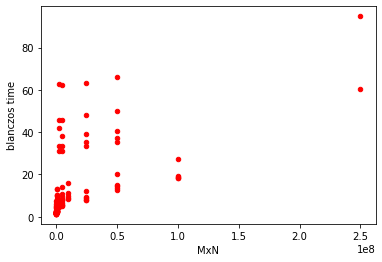

In [13]:
big_df.plot(kind='scatter',x='MxN',y='blanczos time',color='red')
big_df.plot(kind='scatter',x='MxN',y='hail pca time',color='blue')
plt.show()